# Implementing Inria Dataset

**Objectif:** le but de ce notebook est d'expliquer les différentes parties du dataset Inria.

### Root Variables 

In [1]:
import os 

In [2]:
root = '/home/ign.fr/ttea/Code_IGN/AerialImageDataset'
train_dir = os.path.join(root,'train/images')
gt_dir = os.path.join(root,'train/gt')
test_dir = os.path.join(root,'test/images')

### Import Libraries 

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

import torch
from torch.utils.data import Dataset, DataLoader

import rasterio
from rasterio.plot import reshape_as_image
from rasterio.windows import Window

## Inria Dataset 

L'Étiquetage des images aériennes Inria aborde un thème central de la télédétection : l'étiquetage automatique au pixel près de l'imagerie aérienne
    
    
**Caractéristiques de l'ensemble de données :**

- Couverture de 810 km² (405 km² pour l'entraînement et 405 km² pour les tests)
    
- Imagerie aérienne couleur orthorectifiée avec une résolution spatiale de 0,3 m
    
- Données de vérité terrain pour deux classes sémantiques : construction et non construction (divulguées publiquement uniquement pour le sous-ensemble d'apprentissage)

In [4]:
print("Nombre d'images pour l'entraînement :",len(os.listdir(train_dir)))
print("Nombre d'images pour le test:",len(os.listdir(test_dir)))
print("Nombre d'images vérité terrain:",len(os.listdir(gt_dir)))

Nombre d'images pour l'entraînement : 180
Nombre d'images pour le test: 180
Nombre d'images vérité terrain: 180


## Dataset

Etant donné que le jeu de données d'Inria contient de lourdes images 5000x5000, on a besoin de restructurer ces images pour pouvoir travailler dessus. L'idée est de découper chaque image sous forme de tuiles et de retourner la tuile et sa vérité terrain associée.

La classe **Dataset** prend en entrée : 
- root : la racine qui mène vers le dossier ou est stockée le dataset
- tile size : la taille que l'on souhaite pour tuiler  
- mode : entraînement / validation / test
- transform : Transformation pour la data augmentation 
- filtered : Si l'on choisit des images contenant exclusivement que des Bâtiments ou non 
- part : Après avoir split le dataset en 5 (4 train / 1 validation), choisir une partie

In [5]:
class InriaDataset(Dataset):

    def __init__(self, root, tile_size, mode,part):
        self.root = root
        self.tile_size= tile_size
        self.mode = mode
        self.part = part
        
        # Initialisation des listes d'images 
        self.train_dir = os.path.join(root,'train/images')
        self.gt_dir = os.path.join(root,'train/gt')
        self.test_dir = os.path.join(root,'test/images')

        self.train_images = os.listdir(self.train_dir)
        self.test_images = os.listdir(self.test_dir)
        self.gt_images = os.listdir(self.gt_dir)
        
        # Datalist -> contient toutes les tuiles, only_bat -> contient seulement les tuiles ayant des bâtiments  
        self.datalist = []
        self.only_bat = []
        self.used_tiles = []
        self.tiles = []
        
        score = 0
        label= 'None'
        
        
        # Nombre de tuiles par images 
        # Toutes les images dans le jeu de données Inria ont les mêmes tailles, nous allons utiliser la première 
        # image comme référence 
        with rasterio.open(os.path.join(self.train_dir, self.train_images[0])) as first_img :
            # shape dimension is [C, W, H ]
            images_width = first_img.width
            images_heigth = first_img.height
        
        
        # On détermine la largeur & hauteur de la tuile 
        tile_width = self.tile_size[0]
        tile_heigth = self.tile_size[1]
        
        # Nombre de tuiles par colonnes & lignes, ainsi que le nobmre de tuile par image 
        nb_tile_col = images_width // tile_width
        nb_tile_row = images_heigth // tile_heigth
        self.nb_tile_by_image = nb_tile_col*nb_tile_row
            
        for id_image in range(0, len(self.train_images)):
            train_image = self.train_images[id_image]
            gt_image = self.gt_images[id_image]
            for id_tile in range(0, self.nb_tile_by_image):
                self.datalist.append((id_tile, train_image, gt_image))

        self.used_tiles = self.datalist


        # Split le dataset en 80/20 (Train/Valid)
        slice_20= int(len(self.used_tiles)*(0.2))
        
        # On divise le dataset en 5 partie (4 pour l'entraînement, 1 pour la validation)
        
        # 1/5 -> validation is 1/5
        if self.part == 1 :
            if self.mode == 'train':
                del self.used_tiles[:slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[:slice_20]
       
        # 2/5
        if self.part == 2:
            if self.mode == 'train':
                del self.used_tiles[slice_20:2*slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[slice_20:2*slice_20]
        
        # 3/5
        if self.part == 3:
            if self.mode == 'train':
                del self.used_tiles[2*slice_20:3*slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[2*slice_20:3*slice_20]
        # 4/5
        if self.part == 4:
            if self.mode == 'train':
                del self.used_tiles[3*slice_20:4*slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[3*slice_20:4*slice_20]
        # 5/5
        if self.part == 5:
            if self.mode == 'train':
                del self.used_tiles[4*slice_20:]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[4*slice_20:]
            
        # test mode 
        else: 
            self.images = self.test_images
            
    def __len__(self):
        
        return len(self.tiles)

    def __getitem__(self, idx):
        
        if self.mode =='test':
            root = self.test_dir
        else:
            root = self.train_dir
        
        tile_data = self.tiles[idx]
        id_image, id_tile = tile_data[1], tile_data[0]
                    
        image = self._get_tile(self.train_dir, id_image, id_tile)
        mask = self._get_tile(self.gt_dir, id_image, id_tile)   
        mask[np.where(mask==255)] = 1
        
        image_tensor = torch.from_numpy(image).float()
        mask_tensor = torch.from_numpy(mask)
        
        return image_tensor, mask_tensor[0,:,:]
    
    
    def _get_tile(self, root, image_file, idx):
        
        with rasterio.open(os.path.join(root, image_file)) as dataset :

            width = dataset.width
            height= dataset.height

            tile_width = self.tile_size[0]
            tile_height = self.tile_size[1]

            nb_tile_w = width // tile_width
            nb_tile_h = height // tile_height

            row, col = divmod(idx, nb_tile_w)

            tile = dataset.read(window=Window(col*tile_height,row*tile_width,tile_size[0],tile_size[1]))
            return tile  

### Dataloader 

In [6]:
tile_size = (256,256)
train_dataset = InriaDataset(root, tile_size, 'train',1)
val_dataset =  InriaDataset(root, tile_size, 'validation',1)

train_dataloader = DataLoader(train_dataset, 8, num_workers=6,  drop_last=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, 8, num_workers=6, drop_last=True)

### InriaDataset with filter 

On va rajouter l'option transform, filtered, part, cela va nous permettre de choisir si l'on souhaite faire de la data augmentation, de choisir des tuiles n'ayant que des bâtiments.

In [7]:
class InriaDataset_filtered(Dataset):

    def __init__(self, root, tile_size, mode, transform, filtered,part):
        self.root = root
        self.tile_size= tile_size
        self.mode = mode
        self.transform = transform
        self.filtered = filtered   
        self.part = part
        
        # Initialisation des listes d'images 
        self.train_dir = os.path.join(root,'train/images')
        self.gt_dir = os.path.join(root,'train/gt')
        self.test_dir = os.path.join(root,'test/images')

        self.train_images = os.listdir(self.train_dir)
        self.test_images = os.listdir(self.test_dir)
        self.gt_images = os.listdir(self.gt_dir)
        
        # Datalist -> contient toutes les tuiles, only_bat -> contient seulement les tuiles ayant des bâtiments  
        self.datalist = []
        self.only_bat = []
        self.used_tiles = []
        self.tiles = []
        
        score = 0
        label= 'None'
        
        
        # Nombre de tuiles par images 
        # Toutes les images dans le jeu de données Inria ont les mêmes tailles, nous allons utiliser la première 
        # image comme référence 
        with rasterio.open(os.path.join(self.train_dir, self.train_images[0])) as first_img :
            # shape dimension is [C, W, H ]
            images_width = first_img.width
            images_heigth = first_img.height
        
        
        # On détermine la largeur & hauteur de la tuile 
        tile_width = self.tile_size[0]
        tile_heigth = self.tile_size[1]
        
        # Nombre de tuiles par colonnes & lignes, ainsi que le nobmre de tuile par image 
        nb_tile_col = images_width // tile_width
        nb_tile_row = images_heigth // tile_heigth
        self.nb_tile_by_image = nb_tile_col*nb_tile_row

        if filtered == True :
            for id_image in range(0, len(self.train_images)):
                train_image = self.train_images[id_image]
                gt_image = self.gt_images[id_image]
                for id_tile in range(0, self.nb_tile_by_image):

                    mask = self._get_tile(self.gt_dir, train_image, id_tile)
                    mask[np.where(mask==255)] = 1

                    # Détermine le score et l'étiquettage du masque
                    score = (mask==1).sum() / np.shape(mask)[1]

                    if score >0:
                        label = 'Batiment'
                    else:
                        label = 'None'
                    self.datalist.append((id_tile, train_image, gt_image, score, label))
        else: 
            for id_image in range(0, len(self.train_images)):
                train_image = self.train_images[id_image]
                gt_image = self.gt_images[id_image]
                for id_tile in range(0, self.nb_tile_by_image):
                    self.datalist.append((id_tile, train_image, gt_image, None, None))
                    
        self.used_tiles = self.datalist
        if filtered == True:
            for data_tuple in self.datalist:
                if data_tuple[4] == 'Batiment':
                    self.only_bat.append(data_tuple)
            self.used_tiles = self.only_bat

        
        # Split le dataset en 80/20 (Train/Valid)
        slice_20= int(len(self.used_tiles)*(0.2))
        
        # On divise le dataset en 5 partie (4 pour l'entraînement, 1 pour la validation)
        
        # 1/5 -> validation is 1/5
        if self.part == 1 :
            if self.mode == 'train':
                del self.used_tiles[:slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[:slice_20]
       
        # 2/5
        if self.part == 2:
            if self.mode == 'train':
                del self.used_tiles[slice_20:2*slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[slice_20:2*slice_20]
        
        # 3/5
        if self.part == 3:
            if self.mode == 'train':
                del self.used_tiles[2*slice_20:3*slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[2*slice_20:3*slice_20]
        # 4/5
        if self.part == 4:
            if self.mode == 'train':
                del self.used_tiles[3*slice_20:4*slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[3*slice_20:4*slice_20]
        # 5/5
        if self.part == 5:
            if self.mode == 'train':
                del self.used_tiles[4*slice_20:]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[4*slice_20:]
            
        # test mode 
        else: 
            self.images = self.test_images
            
    def __len__(self):
        
        return len(self.tiles)

    def __getitem__(self, idx):
        
        if self.mode =='test':
            root = self.test_dir
        else:
            root = self.train_dir
        
        tile_data = self.tiles[idx]
        id_image, id_tile = tile_data[1], tile_data[0]
                    
        image = self._get_tile(self.train_dir, id_image, id_tile)
        mask = self._get_tile(self.gt_dir, id_image, id_tile)   
        mask[np.where(mask==255)] = 1
        
        image_tensor = torch.from_numpy(image).float()
        mask_tensor = torch.from_numpy(mask)
        
        return image_tensor, mask_tensor[0,:,:]
    
    
    def _get_tile(self, root, image_file, idx):
        # Read Image 
        with rasterio.open(os.path.join(root, image_file)) as dataset :

            width = dataset.width
            height= dataset.height

            tile_width = self.tile_size[0]
            tile_height = self.tile_size[1]

            # Number of tile 
            nb_tile_w = width // tile_width
            nb_tile_h = height // tile_height

            row, col = divmod(idx, nb_tile_w)

            tile = dataset.read(window=Window(col*tile_height,row*tile_width,tile_size[0],tile_size[1]))
            return tile  

### DataLoader

Pour le dataloader, on va diviser le dataset sous forme de batch. 

In [8]:
# InriaDataloader : root,batch_size,tile_loader, tile_size ,mode,transform, filtered , part
tile_size = (256,256)
train_dataset = InriaDataset_filtered(root, tile_size, 'train', None, False,1)
val_dataset =  InriaDataset_filtered(root, tile_size, 'validation', None, False,1)

train_dataloader = DataLoader(train_dataset, 8, num_workers=6,  drop_last=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, 8, num_workers=6, drop_last=True)

**La fonction view prend en entrée :**
- Dataset
- Idx : l'indice pour sélectionner une tuile 

In [9]:
def view(dataset, idx):
    """
    dataset: dataset contains tile & mask 
    idx : index 
    
    Returns : plot tile & mask  
    """
    
    item = dataset[idx]
    
    raster_tile = reshape_as_image(np.array(item[0]).astype(np.uint8))
    raster_gt = reshape_as_image(np.array(item[1][None,:,:]))
    
    figure, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,6))
    
    ax[0].imshow(raster_tile)
    ax[0].set_title('Raster Tile')
    ax[0].set_axis_off()
    
    ax[1].imshow(raster_gt)
    ax[1].set_title('Raster Gt')
    ax[1].set_axis_off()
    
    plt.tight_layout()
    plt.show()

On visualise une image du dataset et son masque associé.

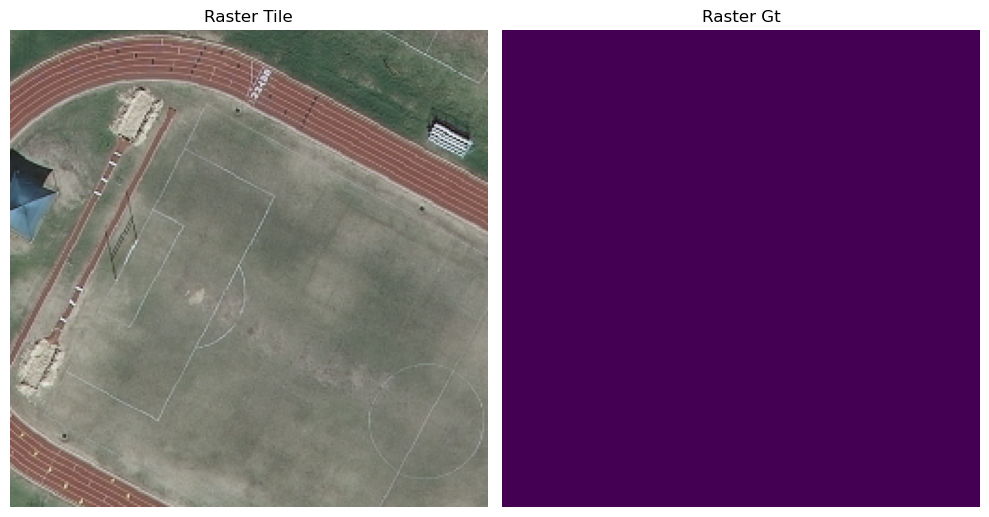

In [10]:
view(train_dataset, 5042)

La fonction view batch permet d'afficher les images et masques par batch 

In [11]:
def view_batch(tiles, gt , pred = None, size = None, ncols = None):
    
    batch_size = tiles.shape[0]
    ncols = batch_size
    if size is not None :
        ncols = size
        
    if pred is None :
        figure, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(20, 8))    
    else : 
        figure, ax = plt.subplots(nrows=3, ncols=ncols, figsize=(20, 12))    
        
    for idx in range(ncols):
        
        item_tile = tiles[idx]
        item_gt = gt[idx]

        raster_tile = reshape_as_image(np.array(item_tile).astype(np.uint8))
        raster_gt = reshape_as_image(np.array(item_gt[None,:,:]))

        ax[0][idx].imshow(raster_tile)
        ax[0][idx].set_axis_off()

        ax[1][idx].imshow(raster_gt)
        ax[1][idx].set_axis_off()
        
        if pred is not None :
            item_pred = pred[idx]
            raster_pred = reshape_as_image(np.array(item_pred[None,:,:]))
            ax[2][idx].imshow(raster_pred)
            ax[2][idx].set_axis_off()

    plt.tight_layout()
    plt.show()

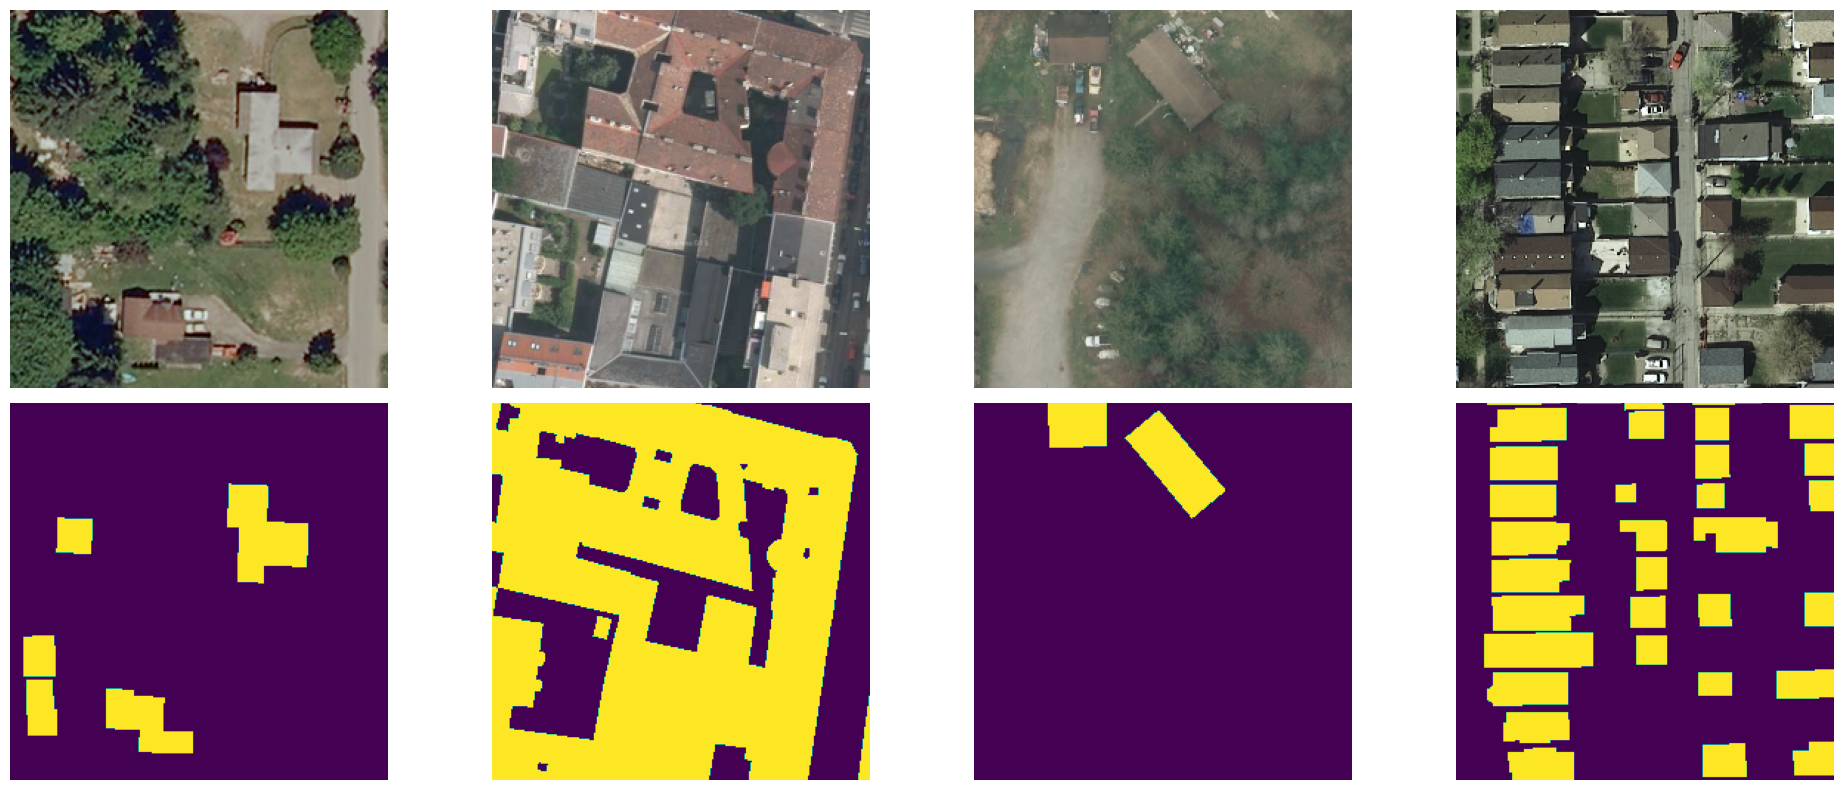

In [12]:
tiles_1, gt_1 = next(iter(train_dataloader))
view_batch(tiles_1, gt_1 , size = 4)